In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
pd.pandas.set_option('display.max_columns',None)

In [39]:
train_data = pd.read_csv("../main_dataset/train.csv")
print(train_data.shape)

(891, 12)


In [40]:
test_data = pd.read_csv("../main_dataset/test.csv")
print(test_data.shape)

(418, 11)


In [41]:
# there were no Zero Variances while Doing the EDA

In [42]:
train_features_with_na=[features for features in train_data.columns if train_data[features].isnull().sum()>=1]
for feature in train_features_with_na:
    print(feature, np.round(train_data[feature].isnull().mean()*100, 2),  ' % missing values')

Age 19.87  % missing values
Cabin 77.1  % missing values
Embarked 0.22  % missing values


In [43]:
test_features_with_na=[features for features in test_data.columns if test_data[features].isnull().sum()>=1]
for feature in test_features_with_na:
    print(feature, np.round(test_data[feature].isnull().mean()*100, 2),  ' % missing values')

Age 20.57  % missing values
Fare 0.24  % missing values
Cabin 78.23  % missing values


In [44]:
# by looking at this data we can Drop the Cabin Column as more than 70 % of the Data is missing
# for Others we need to fill the Missing value

In [8]:
train_data.drop(["Cabin","Name","Ticket"], axis=1, inplace=True)
test_data.drop(["Cabin","Name","Ticket"], axis=1, inplace=True)

In [9]:
test_data['Fare'] = test_data['Fare'].fillna(test_data.groupby('Pclass')['Fare'].transform('median'))

In [10]:
test_data['Fare'].isnull().mean()*100

0.0

In [11]:
train_data['Age'] = train_data['Age'].fillna(train_data.groupby('Pclass')['Age'].transform('mean'))
test_data['Age'] = test_data['Age'].fillna(test_data.groupby('Pclass')['Age'].transform('mean'))

In [12]:
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

In [13]:
set(train_data['Embarked'])

{'C', 'Q', 'S'}

In [14]:
train_features_with_na=[features for features in train_data.columns if train_data[features].isnull().sum()>=1]
for feature in train_features_with_na:
    print(feature, np.round(train_data[feature].isnull().mean()*100, 2),  ' % missing values')

In [15]:
test_features_with_na=[features for features in test_data.columns if test_data[features].isnull().sum()>=1]
for feature in test_features_with_na:
    print(feature, np.round(test_data[feature].isnull().mean()*100, 2),  ' % missing values')

In [16]:
# Missing Value has been Handeled

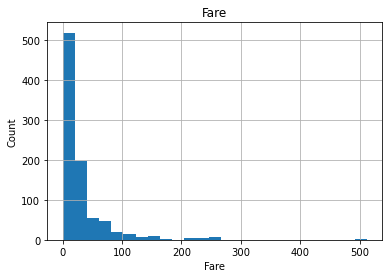

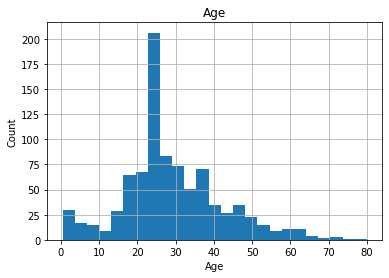

In [17]:
for feature in ['Fare','Age']:
    data=train_data.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [19]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        #1st quartile
        Q1 = np.percentile(df[c],25)
        #3rd quartile
        Q3 = np.percentile(df[c],75)
        #IQR
        IQR = Q3-Q1
        #Outlier Step
        outlier_step= IQR * 1  # Consedering 1.5 for 3mu which is 99% ,Consider 1 for only 2 mu which is 95 %
        #Detect outlier and their indices
        outlier_list_col = df[(df[c]<Q1 - outlier_step) | (df[c]> Q3 + outlier_step)].index
        #store indices
        outlier_indices.extend(outlier_list_col)    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i,v in outlier_indices.items() if v > 1)
    
    return multiple_outliers

In [26]:
lst = [i for i in train_data.columns if i == 'Fare' or i == 'Age']
print(detect_outliers(train_data,lst))

[54, 124, 195, 268, 275, 297, 305, 366, 438, 445, 496, 513, 587, 659, 745, 829, 879]


In [27]:
train_data = train_data.drop(detect_outliers(train_data,lst),axis=0).reset_index(drop = True) # "price",

In [28]:
# by Looking at this data Age is close to Normally Distributed
# only the Fare Feature is not Normally Distributed

In [29]:
def coorilation_detection(data, features = None):
    corrmat = data.corr()
    columns = features if features != None else [ i for i in data.columns if (data[i].dtype in ['int32','int64','float32','float64'] ) ]
    coorilated_variables = {}
    for variable in columns:
        for variable1 in columns:
            if variable == variable1:
                continue
            elif abs(corrmat[variable][variable1]) >= 0.75:
                if ((variable not in coorilated_variables.keys()) and 
                    (variable1 not in coorilated_variables.keys())): 
                    coorilated_variables[variable] = []
                    coorilated_variables[variable].append(variable1)
                elif (variable1 not in coorilated_variables.keys()):  
                    coorilated_variables[variable].append(variable1)
    return coorilated_variables      

In [30]:
lst = [i for i in train_data.columns if (i != 'Survived' and train_data[i].dtype in ['int32','int64','float32','float64'])]
coorilation_detection(train_data, lst)

{}

In [31]:
# There are no Highly Coorilation in the Data

In [32]:
# as this is a Clasification as a result we need to do the Scaling there

In [33]:
categorical_features=[feature for feature in train_data.columns if train_data[feature].dtype=='O']

In [34]:
#labeling the Categorical data
for feature in categorical_features:
    labels_ordered=train_data.groupby([feature])['Survived'].mean().sort_values().index
    labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}
    train_data[feature]=train_data[feature].map(labels_ordered)
    # in the Test Data there are some new category in the feature data
    for category in test_data[feature].unique():
        if category not in labels_ordered:
            labels_ordered[category] = len(labels_ordered)
    test_data[feature]=test_data[feature].map(labels_ordered)

In [35]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,1
1,893,3,1,47.0,1,0,7.0000,0
2,894,2,0,62.0,0,0,9.6875,1
3,895,3,0,27.0,0,0,8.6625,0
4,896,3,1,22.0,1,1,12.2875,0


In [36]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,2
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0


In [37]:
train_data.to_csv('../main_dataset/train_processed_data.csv',index=False)
test_data.to_csv('../main_dataset/test_processed_data.csv',index=False)